# CC5215: Privacidad de Datos

## Laboratorio 6

Integrantes:

- Francisco Gutiérrez Albornoz

In [223]:
# Load the data and libraries
import pandas as pd
import numpy as np
import random
from scipy import stats
import matplotlib.pyplot as plt

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

adult = pd.read_csv('https://users.dcc.uchile.cl/~mtoro/cursos/cc5215/adult_with_pii.csv')

## Question 1 (6 points)

- Implement the Gaussian mechanism.
- How do the Laplace and Gaussian mechanisms compare in terms of relative error on the query "how many individuals are over 50 years old" with $\epsilon = 1$ and $\delta = 10^{-5}$?

In [224]:
def gaussian_mech(v, sensitivity, epsilon, delta):
    sigma = np.sqrt(2 * np.log(1.25 / delta) * sensitivity / epsilon)
    return v + np.random.normal(loc=0, scale=sigma)

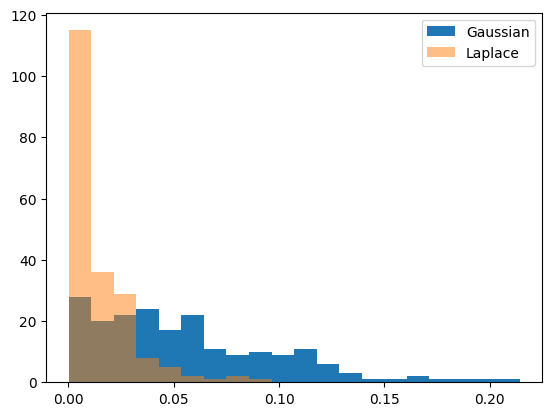

In [225]:
true_answer = len(adult[adult['Age'] > 50])

laplace_answers = [laplace_mech(true_answer, 1, 1) for _ in range(200)]
gaussian_answers = [gaussian_mech(true_answer, 1, 1, 10e-5) for _ in range(200)]

laplace_error = [pct_error(true_answer, a) for a in laplace_answers]
gaussian_error = [pct_error(true_answer, a) for a in gaussian_answers]

_, bins, _ = plt.hist(gaussian_error, bins=20, label='Gaussian')
plt.hist(laplace_error, bins=bins, label='Laplace', alpha=0.5)
plt.legend()

*YOUR ANSWER HERE*

El mecanismo laplaciano tiene una mayor cantidad de errores pequeños (cercanos a cero) mientras que el gausiano tiene errores mayores esto es debido a que el mecanismo gaussiano genera más ruido que el laplaciano para los parámetros dados.

## Question 2 (4 points)

The function `age_cdf` calculates the cumulative distribution function (CDF) of the ages in the adult dataset, expressed as a vector of counts.

What is the **L1 global sensitivity** of `age_cdf`? Justify your answer using the definition of the L1 norm, and the sensitivity of vectors.

Length of CDF vector: 100


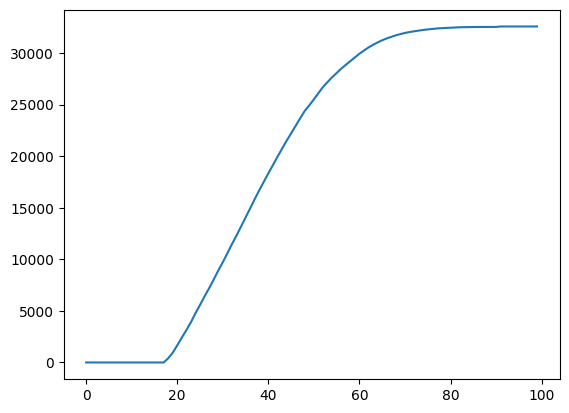

In [226]:
def age_cdf():
    a = adult['Age']
    return [len(a[a < i]) for i in range(100)]

plt.plot(age_cdf());
print('Length of CDF vector:', len(age_cdf()))

*YOUR ANSWER HERE*

La sensibilidad global $L_1$ sería menor o igual a 99 ya que el peor caso es cuando se agrega un nuevo elemento al vector y se tiene edad 1 entonces todos los elementos siguientes aumentarían en uno (esto no tiene mucho sentido al considerar el gráfico, ya que se espera que tengan una edad mayor o igual a 18. En ese caso sería $GS \leq 81$).

## Question 3 (4 points)

- What is the **L2 global sensitivity** of `age_cdf`? Justify your answer using the definition of the L2 norm, and the sensitivity of vectors.
  
  *Respuesta*: Considerando la explicación de la respuesta anterior y lo visto en clases, la sensibilidad global $L_2$ es $\sqrt{99} (= \sqrt{1^2 +...+1^2}) \approx 10$

- How does the L2 global sensitivity compares to the L1 norm sensitivity of `age_cdf`?

    *Respuesta*: En clases se vio que $L_1 \geq L_2$ y con esto se tiene que $GS_{L_1} \geq GS_{L_2}$, y es justamente lo que se tiene acá.

## Range Queries

A *range query* counts the number of rows in the dataset which have a value lying in a given range. For example, "how many participants are between the ages of 21 and 33?" is a range query. A *workload* of range queries is just a list of range queries. The code below generates 100 random range queries over ages in the adult dataset.

In [227]:
def range_query(df, col, a, b):
    return len(df[(df[col] >= a) & (df[col] < b)])

random_lower_bounds = [random.randint(1, 70) for _ in range(100)]
random_workload = [(lb, random.randint(lb, 100)) for lb in random_lower_bounds]
real_answers = [range_query(adult, 'Age', lb, ub) for (lb, ub) in random_workload]

print('First 5 queries: ', random_workload[:5])
print('First 5 queries reales: ', real_answers[:5])

First 5 queries:  [(25, 95), (48, 58), (15, 92), (58, 82), (64, 68)]
First 5 queries reales:  [26991, 4817, 32561, 3286, 687]


## Question 4 (4 points)

Write code to answer a workload of range queries using `laplace_mech` and sequential composition. Your solution should have a **total privacy cost of epsilon**.

In [228]:
def workload_laplace(workload, epsilon):
    epsilon_i = epsilon / len(workload) 
    noisy_answers = []
    for (lb, ub) in workload:
        real_answer = range_query(adult, 'Age', lb, ub)
        noisy_answer = laplace_mech(real_answer, 1, epsilon_i)
        noisy_answers.append(noisy_answer)

    return noisy_answers

print('First 4 answers:', workload_laplace(random_workload, 1.0)[:4])

First 4 answers: [26758.50935559198, 4813.6671944568025, 32326.31475388555, 3513.5509955441426]


In [229]:
errors = [abs(r_a - l_a) for (r_a, l_a) in zip(real_answers, workload_laplace(random_workload, 1.0))]
print('Average absolute error:', np.mean(errors))
assert np.mean(errors) > 50
assert np.mean(errors) < 200

Average absolute error: 111.56131673231027


## Question 5 (8 points)

Write code to answer a workload using `laplace_mech`. Your solution should *not* use sequential composition, and should have a total privacy cost of `epsilon`, justified by the vector-valued Laplace mechanism.

*Hint*: remember to use L1 global sensitivity.

In [230]:
def workload_laplace_vec(workload, epsilon):
    global_sensitivy = len(workload)-1 # 99 en este caso
    true_answers = np.array([range_query(adult, 'Age', lb, ub) for (lb, ub) in workload])
    noise = np.random.laplace(loc=0, scale=global_sensitivy/epsilon, size=len(workload))
    return true_answers + noise

print('First 4 answers:', workload_laplace_vec(random_workload, 1.0)[:4])

First 4 answers: [27019.58109185  4932.78721752 32502.08713979  3222.01146106]


In [231]:
errors = [abs(r_a - l_a) for (r_a, l_a) in zip(real_answers, workload_laplace_vec(random_workload, 1.0))]
print('Average absolute error:', np.mean(errors))
assert np.mean(errors) > 50
assert np.mean(errors) < 200

Average absolute error: 86.98739674787421


## Question 6 (4 points)

In 2-5 sentences, answer the following:
- Did the two solutions differ in terms of their accuracy?
- How do they differ in terms of their use of composition properties of differential privacy?

*YOUR ANSWER HERE*

- Con los resultados anteriores, observamos que la precisión es similar con ámbos procedimientos. La diferencia está en la cantidad de ruido añadido.

- En la primera se utiliza composición secuencial y se aplica el mecanismo a cada componente por separado lo que genera un aumento en $\epsilon$ (por esto hicimos $\epsilon / n$). En cambio, en la segunda no se utiliza composición pues se aplica el mecanismo al vector completo y esto mejora la privacidad.

## Question 7 (8 points)

Write code to answer a workload using `gaussian_mech_vec` - the version of the Gaussian mechanism for vector-valued queries. Your solution should not use sequential composition, should satisfy $(\epsilon, \delta)$-differential privacy, and should have a total privacy cost of (`epsilon`, `delta`).

*Hint*: remember to use L2 sensitivity.

In [232]:
def workload_gaussian_vec(workload, epsilon, delta):
    sensitivity = np.sqrt(len(workload)-1)
    true_answers = np.array([range_query(adult, 'Age', lb, ub) for (lb, ub) in workload])
    sigma = np.sqrt(2 * np.log(1.25 / delta) * sensitivity / epsilon)
    noise = np.random.normal(loc=0, scale=sigma, size=len(workload))
    return true_answers + noise

print('First 4 answers:', workload_gaussian_vec(random_workload, 1.0, 1e-5)[:4])

First 4 answers: [26990.42803799  4805.24195265 32551.63520354  3294.3238621 ]


In [233]:
errors = [abs(r_a - l_a) for (r_a, l_a) in zip(real_answers, workload_gaussian_vec(random_workload, 1.0, 1e-5))]
print('Average absolute error:', np.mean(errors))
assert np.mean(errors) > 10
assert np.mean(errors) < 100

Average absolute error: 11.884500771938887


## Question 8 (6 points)

In 2-5 sentences, answer the following:
- Of your solutions in questions (4,5,7), which ones rely on *sequential composition*?
- Which solution offers the best accuracy?
- Why does this particular solution yield the best accuracy?

*YOUR ANSWER HERE*
- Solo la solución de la pregunta 4 se basa en composición secuencial.
- La implementación usando el mecanismo gaussiano es con la que se tiene mejor precisión.
- Esto ocurre debido a que la sensibilidad para $L_2$ es mucho menor que para $L_1$, cuando esto ocurre, el mecanismo gaussiano agrega menos ruido comparado con el mecanismo laplaciano.

## Question 9 (10 points)

Use advanced composition to achieve $(1, 10^{-5})$-DP using the laplace mechanism. Write code to calculate the $\epsilon_i$ for each iteration. Then, complete the function `workload_advcom_laplace` that receives the `epsilon_i` **for each iteration** (not the total epsilon).

_Hint_: You will have to calculate the $\epsilon_i$ for each iteration using the advanced composition theorem fixing $\delta' = 10^{-5}$ and $\epsilon' = 1$.

In [234]:
# COMPLETE
delta_p = 1e-5
epsilon_p = 1
k = 100

epsilon_i = epsilon_p / (2 * np.sqrt(2 * k * np.log(1 / delta_p)))

print('epsilon for each iteration:', epsilon_i)

epsilon for each iteration: 0.010419866624665259


In [235]:
def workload_advcomp_laplace(workload, epsilon_i):
    sensitivity = 1
    noisy_answers = []
    for (lb, ub) in workload:
        true_answer = range_query(adult, 'Age', lb, ub)
        noisy_answer = laplace_mech(true_answer, sensitivity, epsilon_i)
        noisy_answers.append(noisy_answer)
    return noisy_answers

advcomp_answers = workload_advcomp_laplace(random_workload, epsilon_i)
print('First 4 answers:', advcomp_answers[:4])

First 4 answers: [26920.577593057675, 4743.357953177949, 32770.26167749977, 2955.129577091883]


In [236]:
errors = [abs(r_a - l_a) for (r_a, l_a) in zip(real_answers, advcomp_answers)]
print('Average absolute error:', np.mean(errors))
assert np.mean(errors) > 50
assert np.mean(errors) < 200

Average absolute error: 104.8359738608363


## Question 10 (6 points)

In 2-5 sentences, answer the following:
- How does this solution compare to the result of question 4? Explain in terms of the used epsilons and the concepts seen in class.
- With $\delta'$ fixed in $10^{-5}$, what property of the workload (seen in class) favors the more accurate solution?
- What could we expect if the workload had 50 queries?

*YOUR ANSWER HERE*
- En la ejecución que uso para responder esto, se tiene un error absoluto menor para composición avanzada comparada con la tradicional. Pero es un valor no mucho menor y esto puede deberse a la cantidad de queries que están siendo consideradas. Se espera que si se aumenta el tamaño de `workload`, se tenga una diferencia mucho mayor en cuanto a error en favor de la composición avanzada.
- El tamaño del `workload` influye en esto ya que $\epsilon$ escala con $\sqrt{k}$ (en la composición secuencial tradicional escala con $k$) esto genera un menor ruido y por lo tanto se tiene mejor precisión. 
- Se esperaría que la composición secuencial tradicional tuviera mejores resultados en término de privacidad.